## 範例目標

* 比較 CNN 與 DNN 參數量和準確度的差異

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 10)


## 定義函數

In [6]:
class AbstractTrainer:

    def __init__(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=128, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self._model = None
        self._history = None

    @property
    def optimizer(self):
        return RMSprop(lr=self.learning_rate)

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        raise NotImplementedError('`{}` method `{}` hasn\'t been implemented.'.format(self, '_build'))

    def _launch(self):
        print('Experiment with trainer: {}'.format(self.__class__.__name__))
        self._model.summary()
        self._history = self._model.fit(
            self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=self.validation_data, shuffle=True, verbose=2)
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(8, 6,))
        plt.plot(self._history.history[train_name])
        plt.plot(self._history.history[val_name])
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

class CNNTrainer(AbstractTrainer):
    
    def _build(self):
        model = self._model = Sequential()
        model.add(Conv2D(32, (3, 3,), padding='same', input_shape=self.X_train.shape[1:]))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3,)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2,)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3,), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3,)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2,)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.50))
        model.add(Dense(self.y_train.shape[-1]))
        model.add(Activation('softmax'))
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

class DNNTrainer(AbstractTrainer):
    
    def _build(self):
        model = self._model = Sequential()
        model.add(Flatten(input_shape=self.X_train.shape[1:]))
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.20))
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.20))
        model.add(Dense(self.y_train.shape[-1]))
        model.add(Activation('softmax'))
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

## DNN

由於 DNN 只能輸入一維資料，必須先將影像進行攤平，維度 (50000, 32, 32, 3) 的影像攤平後會變成 (50000, 3072)。

In [7]:
trainer = DNNTrainer(X_train, y_train, X_test, y_test).run()

Experiment with trainer: DNNTrainer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)

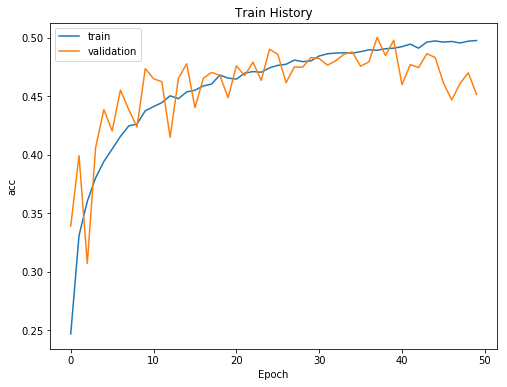

In [8]:
trainer.display('acc', 'val_acc')

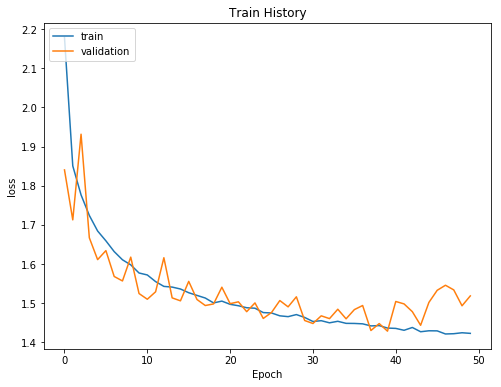

In [9]:
trainer.display('loss', 'val_loss')

## CNN

由於 CNN 的原理非常適合處理影像類的資料，同樣的訓練條件，CNN 是否顯著優於 DNN 呢？

In [10]:
trainer = CNNTrainer(X_train, y_train, X_test, y_test).run()

Experiment with trainer: CNNTrainer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 

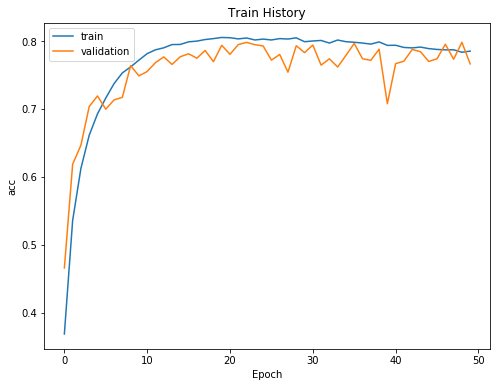

In [11]:
trainer.display('acc', 'val_acc')

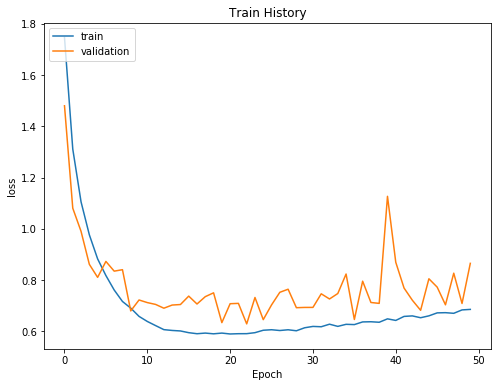

In [12]:
trainer.display('loss', 'val_loss')